<h1><center>Projet de Python pour la Data Science<br /><br />Julien Guibert - Charles Rollet - Tanguy Simeon</center></h1>

#### Bienvenue sur le Github de notre projet Python Pour le Data Scientist ! 

L'objectif du projet est de prédire le prix d'un bien immobilier en fonction de certaines de ses caractéristiques telles que sa surface, son nombre de pièces, sa date de vente, son type (appartement ou maison) et sa location à Paris. 

#### Notre projet ce divise en 6 étapes :

In [1]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

#### Veuillez installer au préalable les packages non conventionnels suivant pour utiliser le reste du programme : 

In [2]:
!pip install customtkinter
!pip install tkcalendar
!pip install tkintermapview
# Ainsi qu'un webdriver (il est conseillé d'utilisé un chromedriver)

#### Ou bien mettre à jour customtkinter :

In [3]:
#!pip install customtkinter -- upgrade

On ignore les messages qui ne sont pas importants (particulièrement utile pour la partie modélisation)

# 1. Web Scraping

#### Notre démarche :<br />

<div style="text-align: justify">Pour créer un estimateur à partir des caractéristiques de biens déjà vendus, encore faut-il précisément avoir de telles données. Après quelques recherches infructueuses, nous avons souhaité effectuer du Web Scraping grâce au module Selenium et avec l'aide d'un web driver. Technique qui nous a paru essentielle pour obtenir des données sur mesures, nous avons trouvé le site ImmoData (https://www.immo-data.fr/) qui fait l'inventaire des biens vendus en France.</div><br />
    
<div style="text-align: justify">Le site Immodata n'affiche que 100 biens par fenêtre de manière aléatoire, ce qui n'était pas assez et peu précis. Afin de collecter un nombre significatif de données, nous avons enfermé Paris dans un rectangle dont les sommets correspondent à des coordonnées puis diviser ce rectangle en 400 petits rectangles afin de cadriller la ville.</div><br />
    
<div style="text-align: justify">Illustration de notre démarche :</div>

#### Explication du code :<br />

<div style="text-align: justify">On importe d'abord les modules nécessaires au fonctionnement de l'algorithme et en particulier Selenium</div>



In [4]:
import argparse
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import time
import logging
from tqdm import tqdm
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

<div style="text-align: justify">Veuillez ensuite indiquer le chemin menant à votre webdriver à installer en fonction de votre moteur de recherche et de sa version (nous vous conseillons d'utiliser un chromedriver)</div>

In [5]:
#path = 'Insérer le chemin de votre webdriver (chromedriver est conseillé)'
path = '/Users/charlesrollet/Desktop/chromedriver-2'

<div style="text-align: justify">On crée une première fonction afin notamment d'afficher la progression du web scraping et on enregistre la base obtenue sous le nom de 'Base_WS_Brute.csv'</div><br />
    
<div style="text-align: justify"> Nota Bene : si le web scraping de s'enclenche pas, il vaut mieux essayer sur spyder par exemple, le code se trouve sur GitHub ou ci-dessous</div>   

In [6]:
def main():
    parser = argparse.ArgumentParser() 
    parser.add_argument('--n', type=int, default=2,help='Number of items to search')
    parser.add_argument('--fn', type=str, default='Base_WS_Brute.csv',help='name of the output CSV file')
    args = parser.parse_args()

    start = time.time()
    n = runImmoDataScrapping(n=args.n, filename= args.fn)
    duration = time.time()-start
    logger.info(f'Scrapped {n} items in {duration/60.} minutes. ({str(duration/n).split(".")[0]} seconds per it)')

<div style="text-align: justify">On crée ensuite la fonction runImmoDataScrapping qui va véritablement effectuer le web scraping. Nous avons effectué une double boucle for qui modifie directement la partie du lien url (grâce à la technique f-string) qui concerne les coordonnées géographiques de l'affichage afin d'effectuer l'encadrement de Paris décrit précedemment. Ainsi Paris est contenu dans un rectangle divisé en 440 petits rectangles que nous allons scrapé.</div><br />

<div style="text-align: justify">Une fois les liens à scrapé définis, nous créons un dataframe de cinq colonnes (adresse, type_bien, prix, prix_m2, details qui contient la suface, le nombre de pièces, la date de vente notamment) que nous remplissons avec les informations scrapées correspondantes.</div>

#### Pour vérifier le bon fonctionnement de l'algorithme, nous vous conseillons de modifier les informations dans le range des deux boucles for en indiquand 256000 à la place de 420030 dans la première et 806001 à la place de 900050 dans la seconde. De cette façon, l'algorithme va scraper 2x2=4 liens (plutôt que 440) ce qui permettra de gagner du temps.

In [7]:
def runImmoDataScrapping(n: int, filename: str):
    for i in range(250000,420030,8501):
        for j in range(800001,900050,5001):
            step_x=2
            step_y=48
            driver = webdriver.Chrome(path)
            url = f"https://www.immo-data.fr/explorateur/transaction/recherche?minprice=0&maxprice=5000000&minpricesquaremeter=0&maxpricesquaremeter=40000&propertytypes=1%2C2&minmonthyear=Janvier%202014&maxmonthyear=Juin%202022&nbrooms=1%2C2%2C3%2C4%2C5&minsurface=0&maxsurface=400&minsurfaceland=0&maxsurfaceland=50000&center={step_x+i*0.000001}%3B{step_y+j*0.000001}&zoom=14.5"
        
            driver.get(url)
            driver.implicitly_wait(6)
            colsInDetailsList = ['addresse','type_bien', 'prix', 'prix_m2', 'details']
            data = {colName : [] for colName in colsInDetailsList}
        
            elements = driver.find_elements(by=By.XPATH, value='//div[@class="flex flex-col gap-2 p-3"]')

            for element in tqdm(elements):
                addresse, prix, type_bien, prix_m2, *details = element.text.split('\n')
                
                data['addresse'].append(addresse)
                data['prix'].append(prix)
                data['type_bien'].append(type_bien)
                data['prix_m2'].append(prix_m2)
                data['details'].append(details)
        
            driver.close()
            if i==250000 and j==800001 : 
                df = pd.DataFrame(data) 
            else : 
                df=pd.concat([df,pd.DataFrame(data)],ignore_index=True)      

    df.to_csv(filename)
    return df.shape[0]

if __name__=='__main__':

    main()

usage: ipykernel_launcher.py [-h] [--n N] [--fn FN]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/charlesrollet/Library/Jupyter/runtime/kernel-0a4e37d0-7d66-41ab-9fb9-4d75c59efe4a.json


SystemExit: 2

Nous avons ainsi réussi à obtenir envrion 44.000 données qu'il nous a ensuite fallu traiter. La base issue du web scraping et intitutée Base_WS_Brute est disponible dans le dossier 'Web Scraping' sur GitHub. 

# 2. Traitement de données 

#### Notre démarche : <br />

<div style="text-align: justify">Si les données récoltées à la suite du web scraping contenaient les informations que nous voulions, celles-ci n'étaient pas optimalement disponibles. En effet, la colonne "détails" par exemple comprenait à la fois le nombre de pièces ainsi, la surface ou encore la date de vente. Or nous souhaitions en faire trois colonnes distinctes afin d'utiliser ces variables individuellement. </div><br />
    
<div style="text-align: justify">C'est pourquoi nous nous sommes attelés à traiter notre base de données avec Pandas. En plus des données obtenues, nous souhaitions aussi en ajouter d'autres et en particulier celles en lien avec les coordonnées géographiques (longitude et latitude) grâce à geopandas des biens afin de les utiliser dans le cadre de notre modèle. </div>

#### Explication du code :<br />  

In [8]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim 
import geopandas
from shapely.geometry import Point

<div style="text-align: justify">On lit la base issue du web scraping ('Base_WS_Brute') en renommant les colonnes.</div>



In [9]:
df = pd.read_csv("/Users/charlesrollet/Desktop/Base_WS_brute.csv",names=['adresse_du_bien', 'valeur_fonciere','type_local', 'prix_m2', 'details'],index_col=0)
indexNames = df[ df['adresse_du_bien'] == 'addresse'].index
df.drop(indexNames , inplace=True)
df.head()

,adresse_du_bien,valeur_fonciere,type_local,prix_m2,details
0.0,5 RUE TABOISE - CLAMART,1 700 000€,Maison,11 806€/m²,"['Pièces', '6', 'Surface', '144', 'm²', 'Terra..."
1.0,24 RUE DESCARTES - MEUDON,742 000€,Maison,14 840€/m²,"['Pièces', '3', 'Surface', '50', 'm²', 'Terrai..."
2.0,6 ALLÉE DE MEUDON - CLAMART,375 000€,Appartement,7 075€/m²,"['Pièces', '2', 'Surface', '53', 'm²', 'Vendu ..."
3.0,18 RUE DE RUSHMOOR - MEUDON,574 800€,Appartement,7 185€/m²,"['Pièces', '4', 'Surface', '80', 'm²', 'Vendu ..."
4.0,8 RUE JEAN BAPTISTE BOUZIAT - CLAMART,292 900€,Appartement,6 657€/m²,"['Pièces', '3', 'Surface', '44', 'm²', 'Vendu ..."


<div style="text-align: justify">On supprime les doublons possibles issus du web scraping. Cette étape est primordiale puisqu'on passe de 44.000 données à environ 13.000.</div>



In [10]:
df.drop_duplicates(keep = 'first', inplace=True)

<div style="text-align: justify">Nous avons ensuite créé trois fonctions permettant soit de supprimer des caractères précis ou d'indiquer les endroits où effectuer les séparations des colonnes.</div>

In [11]:
def func(x):
    if x[0]=='s':
        a=x[1:]
        return str(a)
    else:
         return x

def separator(c):
    return lambda x: pd.Series(str(x).split(c))

def maxi_separator(c, d):
    return lambda x: pd.Series(str(x).split(c, d))

<div style="text-align: justify">On s'occupe d'abord de nettoyer les colonnes 'valeur_fonciere' et 'prix_m2' en supprimant les chaînes de caractères inutiles.</div>



In [12]:
df['prix_m2']=df['prix_m2'].str.split('€/m²').str[0]
df['prix_m2']=df['prix_m2'].str.replace(' ', '')
df['valeur_fonciere']=df['valeur_fonciere'].str.split('€').str[0] 
df['valeur_fonciere']=df['valeur_fonciere'].str.replace(' ', '')
df.head()

,adresse_du_bien,valeur_fonciere,type_local,prix_m2,details
0.0,5 RUE TABOISE - CLAMART,1700000,Maison,11806,"['Pièces', '6', 'Surface', '144', 'm²', 'Terra..."
1.0,24 RUE DESCARTES - MEUDON,742000,Maison,14840,"['Pièces', '3', 'Surface', '50', 'm²', 'Terrai..."
2.0,6 ALLÉE DE MEUDON - CLAMART,375000,Appartement,7075,"['Pièces', '2', 'Surface', '53', 'm²', 'Vendu ..."
3.0,18 RUE DE RUSHMOOR - MEUDON,574800,Appartement,7185,"['Pièces', '4', 'Surface', '80', 'm²', 'Vendu ..."
4.0,8 RUE JEAN BAPTISTE BOUZIAT - CLAMART,292900,Appartement,6657,"['Pièces', '3', 'Surface', '44', 'm²', 'Vendu ..."


<div style="text-align: justify">On supprime ensuite tous les biens qui ne sont pas localisés à Paris et qui viennent du fait que nous avons encadrer Paris qui est de forme ovale dans un rectangle. Ce sont donc les biens en 'coin'.Pour cela, on effectue un test sur la colonne adresse qui consiste à supprimer toutes les lignes dont les cinq derniers caractères sont différents de 'PARIS'. Cette étape nous fait passer de 13.000 données environ à 6.000 données.</div>



In [13]:
indexNames = df[df['adresse_du_bien'].str[-5:]  != 'PARIS'].index
df.drop(indexNames , inplace=True)

<div style="text-align: justify">On nettoye la colonne 'details' pour contruire les colonnes 'nombre_pieces_principales', 'surface_reelle_bati' et 'date_mutation'.</div>



In [14]:
df[['nombre_pieces_principales','poubelle']] = df.details.apply(maxi_separator('Surface', 1))
df[['surface_reelle_bati','poubelle']] = df.poubelle.apply(maxi_separator('m²', 1))
df[['poubelle','date_mutation']] = df.poubelle.apply(maxi_separator('le', 1))
df[['poubelle','nombre_pieces_principales']] = df.nombre_pieces_principales.apply(maxi_separator('Pièces', 1))
df[['date_mutation','poubelle']] = df.date_mutation.apply(maxi_separator('+', 1))
df.drop(['poubelle', 'details'], axis=1, inplace=True)
liste_col = ['nombre_pieces_principales', 'surface_reelle_bati', 'date_mutation']
for col in liste_col:
    df[col]=df[col].str.split(',').str[1]
for col in liste_col:
    df[col]=df[col].str.split("'").str[1]
df.head()

,adresse_du_bien,valeur_fonciere,type_local,prix_m2,nombre_pieces_principales,surface_reelle_bati,date_mutation
707.0,127 RUE MICHEL-ANGE - PARIS,740000,Appartement,9737,3,76,29/06/2022
712.0,31 RUE LE MAROIS - PARIS,598000,Appartement,11074,2,54,28/06/2022
713.0,219 AVENUE DE VERSAILLES - PARIS,620874,Appartement,7304,3,85,28/06/2022
724.0,8 RUE LE MAROIS - PARIS,230000,Appartement,7667,2,30,23/06/2022
734.0,107 BOULEVARD MURAT - PARIS,1380000,Appartement,9787,5,141,17/06/2022


<div style="text-align: justify">On convertit les chaines de caratères numériques en nombres entiers pour les colonnes appropriées.</div>


In [15]:
list_newcolumn = ['valeur_fonciere','prix_m2','nombre_pieces_principales','surface_reelle_bati']
for column in list_newcolumn:
    df[column]=df[column].astype(int)

<div style="text-align: justify">On supprime les données qui semblent de mauvaises qualités par rapport au prix moyen du m2 à Paris.</div>

In [16]:
indexNames = df[(df['prix_m2']< 8000)].index
df.drop(indexNames , inplace=True)
indexNames1 = df[(df['prix_m2']> 20000)].index
df.drop(indexNames1 , inplace=True)

<div style="text-align: justify">Après avoir terminé de traiter les données issues du web scraping, nous avons souhaité en créer de nouvelles en convertissant les adresses des biens en coordonnées géographiques.</div><br />
    
<div style="text-align: justify">Pour cela, nous avons utilisé les modules geopandas et geopy. Nous avons d'abord créé une colonne dans laquelle se trouve les coordonnées des biens avant de supprimer les lignes où ces coordonnées étaient introuvables pour enfin diviser la colonne coordonnée en deux colonnes distinctes contenant les données de longitude et de latitude.</div> 

#### Geopandas est assez demandant en terme de temps, il est conseillé de tester ces commandes pour quelques données. Dans tous les cas, vous retrouverez sous le nom de 'Base_WS_traitee.csv' la base issue de cet algorithme traitement de données. 

<div style="text-align: justify">On supprime les colonnes qui ne sont plus utiles et réordonne celles utiles afin que la base soit similaire à celle du gouv nettoyée.</div>



In [ ]:
geolocator = Nominatim(timeout=5, user_agent = "myGeolocator")
df['coordinates'] = df['adresse_du_bien'].apply(geolocator.geocode)
df = df.dropna() #enlève les lignes avec des 'Nan'
df.reset_index(drop=True) #censer renuméroter le DataFrame mais ça marche pas mdrr
df['longitude'] = df['coordinates'].apply(lambda x: x.point.longitude)
df['latitude'] = df['coordinates'].apply(lambda x: x.point.latitude)

In [ ]:
df.drop(['coordinates', 'adresse_du_bien', 'adresse', 'ville', 'prix_m2'], axis=1, inplace=True)
df = df[['date_mutation','valeur_fonciere','type_local','surface_reelle_bati','nombre_pieces_principales','longitude','latitude']]

In [ ]:
df.head()

<div style="text-align: justify">On peut sauvegarder la base qui est disponible sur GitHub dans le dossier 'Traitement de la base de données issue du WS' et intitulée 'Base_WS_traitee'.</div>



In [17]:
#df.to_csv('Base_WS_traitée_annexe.csv')

#### NOTA BENE : en vue d'effectuer des statistiques descriptives, nous nous sommes aperçus que nos données issues du Web Scraping n'étaient pas forcément homogènes et que certains arrondissements étaient sous ou sur représentés. Nous avons donc run 3 autres fois notre algorithme de Web Scraping puis concaténé ces bases tout en enlevant les doublons ou les données de mauvaises qualités. Ainsi, la base qui est utilisée pour la suite du projet n'est plus  'Base_WS_traitée_annexe.csv' (celle issue du 1er WS) mais 'Base_WS_traitee.csv' qui contient non plus 6.000 données traitées mais 9.000. Cette base est directement accessible dans l'onglet 2 Traitement de la base WS du GitHub

# 3. Statistiques descriptives

#### Notre démarche : <br />

<div style="text-align: justify">Après avoir obtenue une base de données cohérente et nettoyée, nous allons l'analyser avec des statistiques descriptives afin de s'assurer de son homogénéité et trouver quels types de modèles devraient être adaptés à notre base.</div><br />
    
<div style="text-align: justify">Nous allons dans un premier temps reconstitué l'arrondissement d'origine de chaque bien grâce à geopandas pour s'assurer de la bonne répartition des biens. </div>

In [18]:
!pip install plotly_express
!pip install GitPython
!pip install geojson
!pip install fiona

#### NOTA BENE : Afin d'éviter de faire tourner geopandas, nous avons enregistré dans le dossier 3. Statistiques descriptive du GitHub la base 'Base_WS_traitee_stats' mais la manière pour l'obtenir (notamment la reconstruction des arrondissements) est en annexe après la conclusion

In [19]:
import numpy as np
import pandas as pd 
from sklearn import linear_model

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import os
import tempfile
import typing
import tempfile
import geopandas as gpd

In [20]:
df = pd.read_csv("/Users/charlesrollet/Desktop/Base_WS_traitee_stats.csv")
df = df.rename(columns = {'prixm2': 'Prix au m²','code_postal':'Arrondissement', 'surface_reelle_bati':'Surface en m²', 'valeur_fonciere':'Valeur du bien'})
df = df.drop(columns = {'Unnamed: 0'})
df.head()

,date_mutation,Valeur du bien,type_local,Surface en m²,nombre_pieces_principales,longitude,latitude,Arrondissement,Prix au m²
0,29/06/2022,740000,Appartement,76,3,2.257874,48.839415,16,9736.842105
1,28/06/2022,598000,Appartement,54,2,2.260871,48.838515,16,11074.074074
2,28/06/2022,620874,Appartement,85,3,2.257995,48.837945,16,7304.400000
3,23/06/2022,230000,Appartement,30,2,2.260568,48.838470,16,7666.666667
4,17/06/2022,1380000,Appartement,141,5,2.256915,48.839126,16,9787.234043


<div style="text-align: justify"> On s'intéresse d'abord à la répartition des biens afin de s'assurer qu'ils sont distribués de manière homogène dans chaque arrondissement. On remarque que notre base contient un peu plus de bien dans le 16e arrondissement à l'inverse du 1er ou du 6e arrondissement. Cela est sans doute du au fait que la surface du 16e est supérieur à ces deux arrondissement. Or Immodata référencie 100 biens par affichage. Donc plus un arrondissement est grand plus nous allons avoir de données sur celui-ci au vue de la manière dont nous avons construit notre algorithme.</div>

<AxesSubplot:ylabel='Arrondissement'>

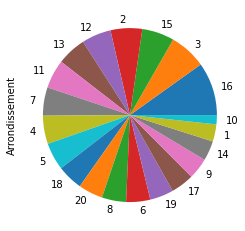

In [21]:
df["Arrondissement"].value_counts(normalize=True).plot(kind='pie')

In [22]:
nbr = df[['Valeur du bien','Arrondissement']].groupby('Arrondissement').count().sort_values(by='Valeur du bien', ascending=False)
nbr.reset_index(0, inplace=True)
nbr.rename(columns={'Valeur du bien':'Nb_annonces'}, inplace=True)
nbr.head(22)

,Arrondissement,Nb_annonces
0,16,890
1,3,617
2,15,540
3,2,530
4,12,493
5,13,490
6,11,482
7,4,474
8,7,474
9,5,460


Nous nous sommes ensuite intéressés au prix moyen du m2 par arrondissement afin de s'assurer de la cohérence de notre base de données. Assez logiquement, les premiers arrondissements sont plus chers.  

In [23]:
prix = df[['Prix au m²','Arrondissement']].groupby('Arrondissement').mean().round().sort_values(by='Prix au m²', ascending=False)
prix.reset_index(0, inplace=True)
prix.head()

,Arrondissement,Prix au m²
0,6,14476.0
1,7,14153.0
2,1,13381.0
3,4,13105.0
4,5,12850.0


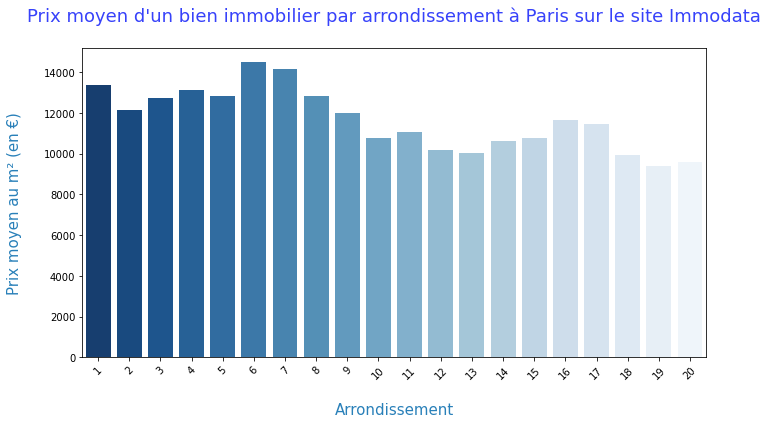

In [24]:
#Diagramme en barre présentant le prix moyen des biens (en m²) par arrondissement
plt.figure(figsize=(10,6))
sns.barplot(x=prix['Arrondissement'], y=prix['Prix au m²'], palette="Blues_r")
plt.xlabel('\nArrondissement', fontsize=15, color='#2980b9')
plt.ylabel('Prix moyen au m² (en €)\n', fontsize=15, color='#2980b9')
plt.title("Prix moyen d'un bien immobilier par arrondissement à Paris sur le site Immodata\n", fontsize=18, color='#3742fa')
plt.xticks(rotation= 45)
plt.tight_layout()

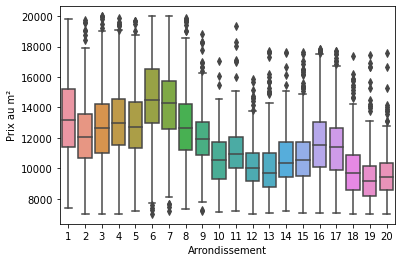

In [25]:
#Boite à moustache représentant la repartition des prix de vente (en m²) pour chaque arrondissement
ax = sns.boxplot(x="Arrondissement", y='Prix au m²', data=df, orient="v")

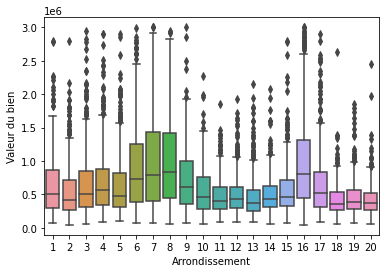

In [26]:
#Boite à moustache représentant la repartition des prix de vente pour chaque arrondissement
ax = sns.boxplot(x="Arrondissement", y='Valeur du bien', data=df, orient="v")

<div style="text-align: justify"> Après s'être assuré de la bonne répartition de nos données et de leur cohérence, nous nous sommes intéressés à la corrélation qu'entretiennent les variables. </div>
    
<div style="text-align: justify"> Sans grande surprise, on observe une forte corrélation entre la surface et le prix du bien ainsi qu'entre la surface et le nombre de pièce. Au vu des autres corrélations, on comprend qu'on a 3 groupe de features : les caractéristiques numériques du bien (surface, nombre de pièce), la localisation du bien (longitude, latitude et arrondissement) et la temporalité avec la date. </div>

Text(0.5, 1.0, 'Matrice de corrélation entre les différentes caractéristiques des annonces\n')

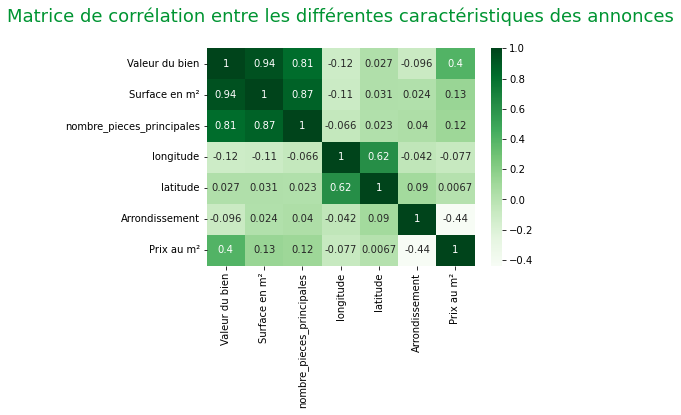

In [27]:
sns.heatmap(df.corr(), annot=True, cmap='Greens')
plt.title("Matrice de corrélation entre les différentes caractéristiques des annonces\n", fontsize=18, color='#009432')

<div style="text-align: justify"> Étant donné la forte corrélation entre le prix et la surface, on décide de représenter nos données dans un plan afin d'en saisir leur répartition en vu de choisir le type de modèles que nous allons tester. </div>

<AxesSubplot:xlabel='Surface en m²', ylabel='Valeur du bien'>

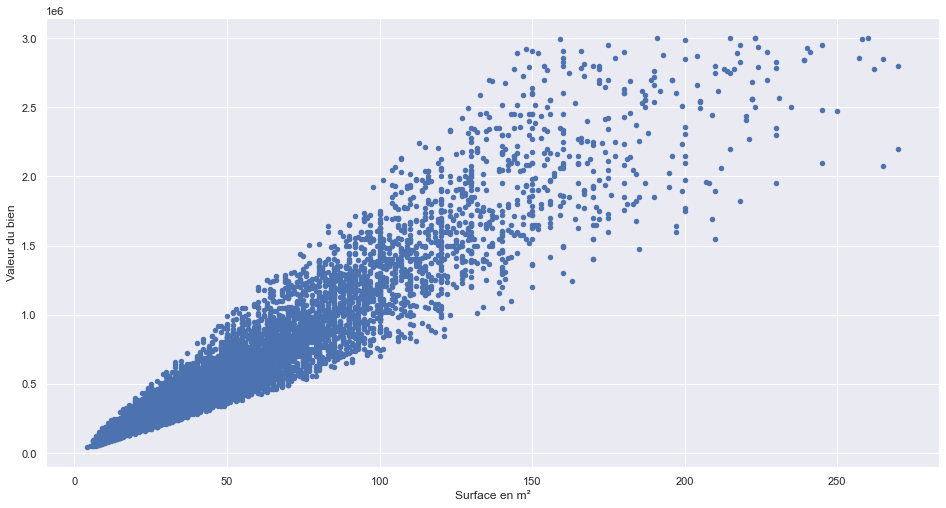

In [28]:
sns.set(rc={'figure.figsize':(16,8.27)})
df.plot.scatter(x='Surface en m²',y='Valeur du bien')

<div style="text-align: justify"> Il semble donc assez clair que nous allons partir sur des modèles de regressions.</div>

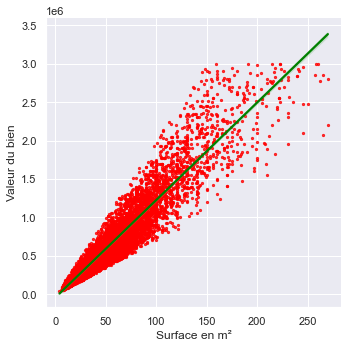

In [29]:
sns.lmplot(x = 'Surface en m²', y = 'Valeur du bien', data = df, scatter_kws = {'s': 5, 'color': 'red'}, line_kws = {'color': 'green'})

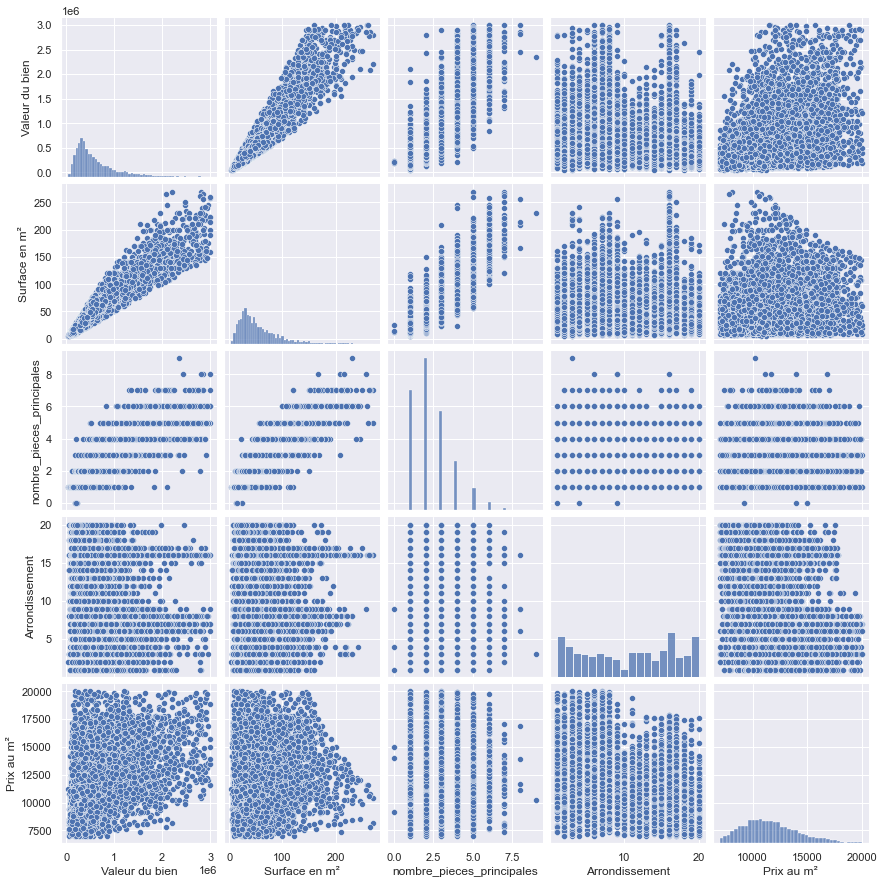

In [30]:
df = df.drop(columns = {'latitude', 'longitude'})
sns.pairplot(df)

# 4. Preprocessing

#### Notre démarche : <br />

<div style="text-align: justify">Notre base comporte à la fois des varibales catégorielles ainsi que des variables continues. Nous avons donc dû traiter les deux types de variables séparément.</div><br />

<div style="text-align: justify">Les variables catégorielles(la date, le nombre de pièces et le type du bien).</div><br /> 

<div style="text-align: justify">Les variables continues (la surface, la longitude et la latitude).</div><br />

<div style="text-align: justify">Nous avons alors créé une fonction nous permettant de choisir le meilleur standardisateur parmis StandardScaler, MinMaxScaler, RobustScaler pour 6 modèles utilisés. </div> 

#### Explication du code :<br />  

<div style="text-align: justify">On importe d'abord plusieurs modules dont les modèles à tester et les standardisateur (LabelEncoder, StandardScaler, RobustScaler,MinMaxScaler) en lien avec sklearn.</div> 


In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler,MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, BayesianRidge
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

In [32]:
df_temp = pd.read_csv('/Users/charlesrollet/Desktop/Base_WS_traitee.csv')

column = ["date_mutation","valeur_fonciere", "type_local","surface_reelle_bati", "nombre_pieces_principales","longitude", "latitude"]
df = df_temp[column]
df.head()

,date_mutation,valeur_fonciere,type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude
0,29/06/2022,740000,Appartement,76,3,2.257874,48.839415
1,28/06/2022,598000,Appartement,54,2,2.260871,48.838515
2,28/06/2022,620874,Appartement,85,3,2.257995,48.837945
3,23/06/2022,230000,Appartement,30,2,2.260568,48.838470
4,17/06/2022,1380000,Appartement,141,5,2.256915,48.839126


#### <div style="text-align: justify">On traite d'abord les variables catégorielles.</div> 



<div style="text-align: justify">On recode en binaire la variable type de bien.</div> 



In [33]:
encoder = LabelEncoder()
df["type_local"]=encoder.fit_transform(df["type_local"])

<div style="text-align: justify">On regroupe les biens de plus de 9 pièces afin d'éviter le bruit que ces varibales pourraient engendrer.</div>



In [34]:
conditions = [df['nombre_pieces_principales']<9, df['nombre_pieces_principales']>=9]
values = [df['nombre_pieces_principales'].values, 'more_than_9']
df['nb_pieces'] = np.select(conditions, values)

<div style="text-align: justify">Pour traiter la date nous avons converti la colonne en datetime puis créé deux nouvelles colonnes contenant l'année de vente et le mois. Nous avons en effet estimé que le jour de vente n'aurait pas réellement d'impact sur l'estimation du prix. Puis nous avons regroupé les mois en demi-trimestres pour gagner en pertinance et regroupé les années antérieures à 2018, jugées anciennes, en une catégorie intitulée 'antérieur_a_2018'. 
</div> 

In [35]:
df["date_mutation"]=pd.to_datetime(df["date_mutation"]) 
df['année'] = df['date_mutation'].dt.year
df['mois'] = df['date_mutation'].dt.month
df.sort_values('date_mutation', ignore_index=True)

# regroupe les mois en trimestre et on trie les années
conditions = [df['mois']<4, (df['mois']>=4) & (df['mois']<7), (df['mois']>=7) & (df['mois']<10),df['mois']>=10]
choiceliste = ['trimestre_1','trimestre_2','trimestre_3','trimestre_4']
df['trimestre'] = np.select(conditions, choiceliste)
conditions = [df['année']<2018, df['année']>=2018]
choiceliste = ['antérieur_a_2018',df['année'].values]
df['année'] = np.select(conditions, choiceliste)


<div style="text-align: justify">Nous avons ensuite encoder ces variables grâce à get_dummies() qui les a converties en indicatrices.</div>



In [36]:
df_test = pd.get_dummies(df, columns = ['trimestre'])
df_annex = pd.get_dummies(df_test, columns = ['année'])
df_final = pd.get_dummies(df_annex, columns = ['nb_pieces'])

<div style="text-align: justify">Création du DataFrame final.</div>

In [37]:
df_new =pd.DataFrame(df_final)
new_list = ['date_mutation','nombre_pieces_principales','mois']
df_new=df_new.drop(new_list,axis=1)
df_new.head()

,valeur_fonciere,type_local,surface_reelle_bati,longitude,latitude,trimestre_trimestre_1,trimestre_trimestre_2,trimestre_trimestre_3,trimestre_trimestre_4,année_2018,...,nb_pieces_0,nb_pieces_1,nb_pieces_2,nb_pieces_3,nb_pieces_4,nb_pieces_5,nb_pieces_6,nb_pieces_7,nb_pieces_8,nb_pieces_more_than_9
0,740000,0,76,2.257874,48.839415,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,598000,0,54,2.260871,48.838515,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,620874,0,85,2.257995,48.837945,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,230000,0,30,2.260568,48.838470,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1380000,0,141,2.256915,48.839126,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


<div style="text-align: justify">On crée les bases features et cibles puis on sépare aléatoirement les bases train et test avec comme proportion 80-20.</div>

In [38]:
Y = pd.DataFrame(df_new["valeur_fonciere"])
X = df_new.drop("valeur_fonciere", axis=1)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=11)

<div style="text-align: justify">On chosisit de réindexer les dataframe afin d'éviter que la réinsersion des colonnes de new_list standardisée pose problème.</div> 

In [39]:
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
Y_train = Y_train.reset_index(drop = True)
Y_test = Y_test.reset_index(drop = True)
X_train.head()

,type_local,surface_reelle_bati,longitude,latitude,trimestre_trimestre_1,trimestre_trimestre_2,trimestre_trimestre_3,trimestre_trimestre_4,année_2018,année_2019,...,nb_pieces_0,nb_pieces_1,nb_pieces_2,nb_pieces_3,nb_pieces_4,nb_pieces_5,nb_pieces_6,nb_pieces_7,nb_pieces_8,nb_pieces_more_than_9
0,0,14,2.257874,48.839415,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,33,2.388017,48.887784,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,30,2.320229,48.886575,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,40,2.405096,48.847194,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,26,2.296519,48.835836,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [40]:
Y_train.head()

,valeur_fonciere
0,188000
1,238550
2,360700
3,369000
4,267000


<div style="text-align: justify">On retire du dataframe X_train les variables continues pour les standardiser.</div>

In [41]:
liste_annexe = ['surface_reelle_bati', 'latitude', 'longitude']
df_continu = X_train[liste_annexe]
df_continu_test = X_test[liste_annexe]

<div style="text-align: justify">On utilise 3 Standardisateurs différents qu'on va tester pour savoir lequel est plus adapté à chaque modèle.</div> 

In [42]:
sc = StandardScaler()
rs = RobustScaler()
minmax = MinMaxScaler()

<div style="text-align: justify">On standardise les variables continues dans les bases train et test selon les 3 standardisateurs choisis.</div> 

In [43]:
scale = sc.fit_transform(df_continu)
df_scale = pd.DataFrame(scale, columns = liste_annexe)
scale_test = sc.transform(df_continu_test)
df_scale_test = pd.DataFrame(scale_test, columns = liste_annexe)

robust = rs.fit_transform(df_continu)
df_robust = pd.DataFrame(robust, columns = liste_annexe)
robust_test = rs.transform(df_continu_test)
df_robust_test = pd.DataFrame(robust_test, columns = liste_annexe)

MinMax = minmax.fit_transform(df_continu)
df_MinMax = pd.DataFrame(MinMax, columns = liste_annexe)
MinMax_test = minmax.transform(df_continu_test)
df_MinMax_test = pd.DataFrame(MinMax_test, columns = liste_annexe)

<div style="text-align: justify">On termine de construire nos bases finales standardisées selon les trois estimateurs.</div> 

In [44]:
X_train_st = X_train.copy()
X_train_rob = X_train.copy()
X_train_mm = X_train.copy()

X_test_st = X_test.copy()
X_test_rob = X_test.copy()
X_test_mm = X_test.copy()

for col in liste_annexe:
    X_train_st[col] = df_scale[col]
    X_test_st[col] = df_scale_test[col]
    
for col in liste_annexe:
    X_train_rob[col] = df_robust[col]
    X_test_rob[col] = df_robust_test[col]
    
for col in liste_annexe:
    X_train_mm[col] = df_MinMax[col]
    X_test_mm[col] = df_MinMax_test[col]

In [45]:
X_train_st.head()

,type_local,surface_reelle_bati,longitude,latitude,trimestre_trimestre_1,trimestre_trimestre_2,trimestre_trimestre_3,trimestre_trimestre_4,année_2018,année_2019,...,nb_pieces_0,nb_pieces_1,nb_pieces_2,nb_pieces_3,nb_pieces_4,nb_pieces_5,nb_pieces_6,nb_pieces_7,nb_pieces_8,nb_pieces_more_than_9
0,0,-1.076582,-0.988423,-0.718816,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,-0.576105,0.600100,1.049925,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,-0.655128,-0.227322,1.005729,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,-0.391719,0.808555,-0.434338,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,-0.760491,-0.516722,-0.849696,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [46]:
X_train_rob.head()

,type_local,surface_reelle_bati,longitude,latitude,trimestre_trimestre_1,trimestre_trimestre_2,trimestre_trimestre_3,trimestre_trimestre_4,année_2018,année_2019,...,nb_pieces_0,nb_pieces_1,nb_pieces_2,nb_pieces_3,nb_pieces_4,nb_pieces_5,nb_pieces_6,nb_pieces_7,nb_pieces_8,nb_pieces_more_than_9
0,0,-0.714286,-1.845890,-0.827491,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,-0.261905,0.891820,1.172621,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,-0.333333,-0.534185,1.122643,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,-0.095238,1.251078,-0.505800,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,-0.428571,-1.032947,-0.975491,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [47]:
X_train_mm.head()

,type_local,surface_reelle_bati,longitude,latitude,trimestre_trimestre_1,trimestre_trimestre_2,trimestre_trimestre_3,trimestre_trimestre_4,année_2018,année_2019,...,nb_pieces_0,nb_pieces_1,nb_pieces_2,nb_pieces_3,nb_pieces_4,nb_pieces_5,nb_pieces_6,nb_pieces_7,nb_pieces_8,nb_pieces_more_than_9
0,0,0.030303,0.963759,0.962856,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0.102273,0.990511,0.992434,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0.090909,0.976577,0.991695,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0.128788,0.994022,0.967613,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0.075758,0.971703,0.960667,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


<div style="text-align: justify">On crée une fonction pour voir quel est le meilleur standardisateur pour chaque modèle choisi.</div> 

In [48]:
def meilleur_standardiseur(model_name):
    
    better_score = 0
    better_scaler = ''

    X_train_list = [X_train_st, X_train_rob, X_train_mm]
    X_test_list = [X_test_st, X_test_rob, X_test_mm]
    scalers = ["Standard", "Robust", "MinMax"]
    
    for i in range(len(X_test_list)):
        model = model_name
        model.fit(X_train_list[i], Y_train)
        score = model.score(X_test_list[i], Y_test)
        if score > better_score:
            better_score = score
            better_scaler = scalers[i]
        elif score == better_score:
            better_scaler += " / " + scalers[i]
    print("Pour le modèle {}, better score {} avec {}.".format(model_name, better_score, better_scaler))

<div style="text-align: justify">On applique la fonction à 6 modèles différents.</div> 

In [49]:
meilleur_standardiseur(LinearRegression())

Pour le modèle LinearRegression(), better score 0.8943661307954835 avec Robust.


In [50]:
meilleur_standardiseur(RandomForestRegressor())


Pour le modèle RandomForestRegressor(), better score 0.9261970126978692 avec MinMax.


In [51]:
meilleur_standardiseur(DecisionTreeRegressor())

Pour le modèle DecisionTreeRegressor(), better score 0.8534555151393904 avec Robust.


In [52]:
meilleur_standardiseur(KNeighborsRegressor())

Pour le modèle KNeighborsRegressor(), better score 0.8974678035799153 avec Standard.


LogisticRegression et SVC sont très long à compiler et on a déjà vu que leur score était très mauvais du fait que ces modèles ne sont pas adaptés à notre situation.  

In [53]:
# meilleur_standardiseur(LogisticRegression())

In [54]:
# meilleur_standardiseur(SVC())

#### <div style="text-align: justify"> Résultat du meilleur standardisateur selon les modèles utilisés : (ces résultats sont suceptinles d'évoluer car la différence de score est très faible)</div> 

|          | Decision Tree Method | Random Forest Method | K Neighbors Classifier | SCV | Logistic Regression | Linear Regression | 
|:--------:| :------------------: | :------------------: | :--------------------: | :--------------------: | :-----------------: | :---------------: |
| Robust   |          ❌          |          ✅          |           ❌           |          ✅            |         ❌          |        ✅        |
| Standard |          ✅          |          ❌           |            ✅           |          ❌            |         ✅          |        ❌        |
| MinMax   |          ❌          |          ❌           |           ❌           |           ❌            |         ❌          |        ❌        |


<div style="text-align: justify">On peut enregistrer les bases train et test standardisés selon le meilleur standardisateur de chaque modèle.</div> 

In [55]:
#X_train_st.to_csv('X_train_st.csv')
#X_train_rob.to_csv('X_train_rob.csv')
#X_train_mm.to_csv('X_train_mm.csv')
#X_test_st.to_csv('X_test_st.csv')
#X_test_rob.to_csv('X_test_rob.csv')
#X_test_mm.to_csv('X_test_mm.csv')
#Y_test.to_csv('Y_test.csv')
#Y_train.to_csv('Y_train.csv')

# 5. Modélisation 

#### Notre démarche : <br />

<div style="text-align: justify">Après avoir choisi le meilleur standardisateur pour chaque modèle utiliser, nous allons créer une fonction permettant de déterminer les hyperparamètres optimaux de chaque modèle parmi ceux sélectionnés.</div><br />

#### Explication du code :<br />  

In [56]:
import numpy as np
import pandas as pd
from statistics import mean
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_squared_log_error

In [57]:
#X_train_st = pd.read_csv('X_train_st.cvs')
#X_train_rob = pd.read_csv('X_train_rob.cvs')
#X_train_mm = pd.read_csv('X_train_mm.cvs')
#X_test_st = pd.read_csv('X_test_st.cvs')
#X_test_rob = pd.read_csv('X_test_rob.cvs')
#X_test_mm = pd.read_csv('X_test_mm.cvs')
#Y_test = pd.read_csv('Y_test.cvs')
#Y_train = pd.read_csv('Y_train.cvs')

<div style="text-align: justify">On définit de dictionnaires concernant les hyperparamètres de chaque modèle selectionné après les avoir cherchés sur Sklearn.</div><br />
    
Nota Bene : si squared_error ne marche pas en fonctionnement de l'environnement, il faut utiliser mse

In [58]:
dico_param_tree = {'decisiontreeregressor__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
         'decisiontreeregressor__splitter': ['best', 'random']}
dico_param_rf = {"randomforestregressor__n_estimators": np.arange(10, 100, 20),
              "randomforestregressor__criterion": ['squared_error', 'absolute_error', 'friedman_mse','poisson'],
              "randomforestregressor__max_features": ['auto', 'sqrt', 'log2']}
dico_param_log = {'logisticregression__solver': ['newton-cg', 'lbfgs', 
                                                 'liblinear', 'sag', 'saga']}
dico_param_knn = {"kneighborsregressor__n_neighbors":np.arange(2, 10, 1),
                 "kneighborsregressor__weights": ['uniform', "distance"],
                 "kneighborsregressor__algorithm": ["auto", "ball_tree", "kd_tree", "brute"]}
dico_param_svc = {'svc__kernel':["linear", "poly", "rbf", "sigmoid"], 
           "svc__gamma":['scale', "auto"],
                 "svc__probability":[True, False]}

<div style="text-align: justify">On utilise ma
    ke_pipeline pour sauvegarder nos modèles et éviter de relancer des calcules conséquents à chaque fois. </div>

In [59]:
model_lr = make_pipeline(LinearRegression())
model_rf = make_pipeline(RandomForestRegressor())
model_tree = make_pipeline(DecisionTreeRegressor())
model_log = make_pipeline(LogisticRegression())
model_knn = make_pipeline(KNeighborsRegressor())
model_svm = make_pipeline(SVC())

<div style="text-align: justify">On crée une fonction qui donne les meilleurs hyperparamètres de chaque modèle. </div>

In [60]:
# On adopte le R2 comme score de base étant dans le cas de regressions. 
SCORING = 'r2' 

# On crée une fonction qui donne les meilleurs hyperparamètres de chaque modèle
def best_param(X, Y, pipeline, dico_param):
    
    # On crée un grid search pour obtenir les meilleurs hyperparamètres
    grid = GridSearchCV(
        pipeline, 
        param_grid=dico_param,  
        cv=3, 
        refit=True,
        scoring=SCORING)
    
    grid.fit(X, Y)
    print(f"Le meilleur estimateur a {SCORING}={round(grid.best_score_, 2)}")
    
    # On garde le meilleur modèle en mémoire 
    best_model = grid.best_estimator_
    print("Le meilleur modèle est :", best_model[0])
    return best_model[0]

In [61]:
best_model_lr = best_param(X_train_st, Y_train, model_lr, {})

Le meilleur estimateur a r2=0.9
Le meilleur modèle est : LinearRegression()


In [62]:
best_model_tree = best_param(X_train_st, Y_train, model_tree, dico_param_tree)

Le meilleur estimateur a r2=0.85
Le meilleur modèle est : DecisionTreeRegressor(criterion='friedman_mse')


In [63]:
best_model_knn = best_param(X_train_st, Y_train, model_knn, dico_param_knn)

Le meilleur estimateur a r2=0.9
Le meilleur modèle est : KNeighborsRegressor(n_neighbors=7, weights='distance')


In [64]:
best_model_rf = best_param(X_train_rob, Y_train, model_rf, dico_param_rf)

Le meilleur estimateur a r2=0.92
Le meilleur modèle est : RandomForestRegressor(criterion='friedman_mse', n_estimators=90)


best_model_svm et best_model_log sont très long à compiler et on a déjà vu que leur score était très mauvais du fait que ces modèles ne sont pas adaptés à notre situation.  

In [65]:
# best_model_svm = best_param(X_train_rob, Y_train, model_svm, dico_param_svc)

In [66]:
# best_model_log = best_param(X_train_st, Y_train, model_log, dico_param_log)

(On remarque que la différence de score entre les modèle ayant les hyperparamètres par défauts et ceux avec les hyperparamètres les plus optimaux n'est pas très grande. Cela est sans doute due au modèle et au traitement de données, l'estimation du prix d'un bien étant assez linéaire) 

<div style="text-align: justify">On crée une fonction pour tester le meilleur modèle selon les hyperparamètres et les manières de standardiser précédemment établis et pour obtenir différents résultats sur ses performances. </div>

In [67]:
def fit(mettre_X_train, mettre_X_test, mettre_Y_train, model):
    
    mean_absolute_error = mean(cross_val_score(model, mettre_X_train, mettre_Y_train, cv=StratifiedKFold(), scoring='neg_mean_absolute_error'))
    mean_squared_error = mean(cross_val_score(model, mettre_X_train, mettre_Y_train, cv=StratifiedKFold(), scoring='neg_mean_squared_error'))
    max_error = mean(cross_val_score(model, mettre_X_train, mettre_Y_train, cv=StratifiedKFold(), scoring='max_error'))
    explained_variance =mean(cross_val_score(model, mettre_X_train, mettre_Y_train, cv=StratifiedKFold(), scoring='explained_variance'))
    mean_poisson_deviance = mean(cross_val_score(model, mettre_X_train, mettre_Y_train, cv=StratifiedKFold(), scoring='neg_mean_poisson_deviance'))
    predict = model.predict(mettre_X_test)
    
    print('mean_absolute_error: {:.3g}'.format(mean_absolute_error))
    print('mean_squared_error: {:.3g}'.format(mean_squared_error))
    print('max_error: {:.3g}'.format(max_error))
    print('explained_variance: {:.3g}'.format(explained_variance))
    print('mean_poisson_deviance: {:.3g}'.format(mean_poisson_deviance))
    
    return mean_absolute_error, mean_squared_error, max_error, explained_variance, mean_poisson_deviance, predict


 <div style="text-align: justify">On applique la fonction au meilleur modèle. </div>

In [68]:
mean_absolute_error_tree, mean_squared_error_tree, max_error_tree, explained_variance_tree, mean_poisson_deviance_tree, predict_tree = fit(X_train_st, X_test_st, Y_train, best_model_tree)

mean_absolute_error: -1.24e+05
mean_squared_error: -3.96e+10
max_error: -1.27e+06
explained_variance: 0.85
mean_poisson_deviance: -3.89e+04


In [69]:
mean_absolute_error_knn, mean_squared_error_knn, max_error_knn, explained_variance_knn, mean_poisson_deviance_knn, predict_knn = fit(X_train_st, X_test_st, Y_train, best_model_knn)

mean_absolute_error: -1.05e+05
mean_squared_error: -2.77e+10
max_error: -1.05e+06
explained_variance: 0.894
mean_poisson_deviance: -2.84e+04


In [80]:
mean_absolute_error_lr, mean_squared_error_lr, max_error_lr, explained_variance_lr, mean_poisson_deviance_lr, predict_lr = fit(X_train_st, X_test_st, Y_train, best_model_lr)

mean_absolute_error: -1.07e+05
mean_squared_error: -2.68e+10
max_error: -1.04e+06
explained_variance: 0.898
mean_poisson_deviance: nan


In [71]:
mean_absolute_error_rf, mean_squared_error_rf, max_error_rf, explained_variance_rf, mean_poisson_deviance_rf, predict_rf = fit(X_train_st, X_test_st, Y_train, best_model_rf)

mean_absolute_error: -9.18e+04
mean_squared_error: -2.15e+10
max_error: -9.66e+05
explained_variance: 0.918
mean_poisson_deviance: -2.09e+04


In [72]:
# mean_absolute_error_log, mean_squared_error_log, max_error_log, explained_variance_log, mean_poisson_deviance_log,predict_log = fit(X_train_st, X_test_st, Y_train, best_model_log)

In [73]:
# mean_absolute_error_svm, mean_squared_error_svm, max_error_svm, explained_variance_svm, mean_poisson_deviance_svm, predict_svm = fit(X_train_st, X_test_st, Y_train, best_model_svm)

In [74]:
predict_rf

array([719555.08888889,  88831.77777778, 217630.77777778, ...,
       908019.51111111, 857642.6       , 435588.57777778])

#### <div style="text-align: justify">Résultats des modèles utilisés (les résultats sont suceptibles de changés en compilant) : </div><br />

|                       | Decision Tree Method | Random Forest Method | K Neighbors Regressor  |     SVC     | Logistic Regression | Linear Regression | 
|:---------------------:| :------------------: | :------------------: | :--------------------: | :---------: | :-----------------: | :---------------: |
| Score                 |         0.85         |         0.92         |          0.89          |     0,1     |         0.01        |        0,89       |      
| mean_absolute_error   |      -1.24e+05       |      -9.19e+04       |       -1.07e+05        |     NaN     |         NaN         |     -1.07e+05     |
| mean_squared_error    |      -3.88e+10       |      -2.16e+10       |       -2.83e+10        |     NaN     |         NaN         |     -2.68e+10     |
| max_error             |      -1.26e+06       |      -9.73e+05       |       -1.04e+06        |     NaN     |         NaN         |     -1.04e+06     |
| explained_variance    |         0.852        |         0.918        |          0.892         |     NaN     |         NaN         |        0.898      |
| mean_poisson_deviance |      -3.89e+04       |      -2.08e+04       |       -2.93e+04        |     NaN     |         NaN         |        NaN        |




Ainsi, nous avons décidé de choisir le modèle Random Forest Regressor avec comme standardiseur Robust et comme hyperparamètres (criterion='friedman_mse', n_estimators=90) pour estimer le prix d'un bien selon certaines de ses caractéristiques. (SVC a des NaN car les scores utilisés sont propres aux regressions). 

Pour finir on crée une fonction qui renvoie les meilleurs features. 



In [75]:
def best_features(model, X_train, seuil) :     
    features_importances = []
    index_best_features = []
    list_results = model.feature_importances_.tolist()
    best_features = []
    for i in range(len(list_results)):
        if list_results[i] > seuil :
            index_best_features.append(i)
            features_importances.append(list_results[i])
            best_features.append(X_train.columns[i])
    return best_features, features_importances

#### <div style="text-align: justify"> Pour le modèle RandomForest Regressor (modèle qui a optenu le meilleur score) on regarde les features les plus importantes : </div>

mean_absolute_error: -9.2e+04
mean_squared_error: -2.14e+10
max_error: -9.86e+05
explained_variance: 0.918
mean_poisson_deviance: -2.09e+04


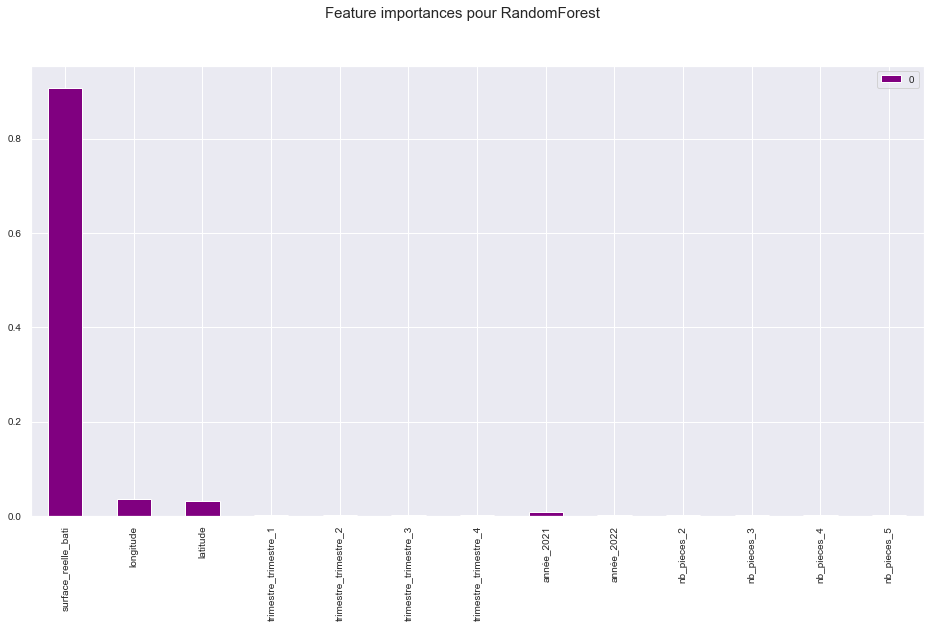

In [76]:
mean_absolute_error, mean_squared_error, max_error, explained_variance, mean_poisson_deviance, predict = fit(X_train_st, X_test_st, Y_train, best_model_rf)

best_features_rf, features_importance_rf = best_features(best_model_rf, X_train_st, 0.001)

pd.DataFrame(features_importance_rf, index = best_features_rf).plot.bar(color='purple')
plt.suptitle('Feature importances pour RandomForest', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.show()

Sans grande surprise, la surface est le feature le plus important. On voit ensuite que la localisation arrive en 2e position suivi de l'année. Cela semble assez logique puisque même s'il y a des prix parfois très élevé à Paris, tous les arrondissements ont en moyenne un prix/m2 à plus de 10.000. Notre modèle ne reflète pas forcément les 

# 6. Visualisation grâce à une interface graphique

#### Notre démarche : <br />

<div style="text-align: justify">Plutôt de rentrer directement les caractéristiques du bien dans Python, nous avons souhaité développer une certaine expérience utilisateur tant pour allier forme et fond que pour créer une interface dynamique. Nous avons aussi voulu utiliser le plus de fonctionalités du module associé à l'interface et c'est pourquoi nous avons varié la nature des widgets utilisés tout en essayant de trouver le plus adapté à l'entrée du paramètre.</div> 

#### Explication du code :<br />  

Pour cela on utilise des modules non convetionnels qu'il faudra installer au préalable tels que tkintermapview, customtkinter ou encore tkcalendar.

In [77]:
import pandas as pd
import numpy as np

#package pour l'affichage graphique
import tkinter as tk
import tkinter.messagebox
import tkintermapview
import customtkinter
import tkcalendar
import geopandas
from geopy.geocoders import Nominatim 

#package pour la récupération des coordonnées des arrondissements de Paris
import geojson 
import folium
import webbrowser

<div style="text-align: justify">Après ce travail préalable, nous avons véritablement créé notre interface et utilisé des widgets différents (Entry, commonbox, button etc.) pour le meilleur rendu possible. Nous avons souhaité créer un compteur pour indiquer le nombre de pièces du bien en liant une fonction + et une fonction - à leur bouton repectif qui modifient le texte d'un Label. </div><br />
    
<div style="text-align: justify">Nous avons aussi introduit un calendrier pour la saisie de la date qui apparait lorsqu'un bouton est actionné et disparait en affichant la date dans un label lorsqu'un autre l'est aussi. Nous avons relié le modèle choisi à l'interface par un bouton central. Lorsque toutes les caractéristiques sont remplies, il ne reste plus qu'à appuyer sur le bouton centrale qui affichera une carte avec la localisation du bien, le prix estimé et la plus value possible en cas de vente si la personne est propriétaire. Enfin, nous avons créé un deuxième onglet Description qui permet d'avoir des informations supplémentaires sur le prix au m2 de notre bien estimé en fonction du marché dans son arrondissement.</div> 

#### NOTA BENE : Il est possible que l'interface apparaisse mal, voire fasse crasher le notebook en fonction de votre environnement. En cas de problèmes, n'hésitez pas à nous envoyer un mail. Vous trouvez une image en fin de rapport. 

In [ ]:
# ======================== Préambule - Récupération coordonnées ========================
 
geo = geojson.load(open("arrondissements.geojson"))

coord_arr = []
poly_arr = []
for i in range(20):
    txt = 'poly' + str(i+1)
    coord_arr.append(txt)
    poly = list(geo["features"][i]["geometry"].values())[1][0]
    for k in range(len(poly)):
        poly[k][0], poly[k][1] = poly[k][1], poly[k][0]
    poly.append(poly[0])
    poly_arr.append(poly)

keys = coord_arr
values = poly_arr
dict_arr = dict(zip(keys, values))




# ======================== Début - AFFICHAGE ========================

customtkinter.set_appearance_mode("System") 
customtkinter.set_default_color_theme("dark-blue") 


class App(customtkinter.CTk):

    WIDTH = 1080
    HEIGHT = 950
    
    def __init__(self):
        super().__init__()

        self.title("Welcome at JCT Company.py")
        self.geometry(f"{App.WIDTH}x{App.HEIGHT}")
        self.protocol("WM_DELETE_WINDOW", self.on_closing) 

        # ======================== create two frames ========================

        # configure grid layout (2x1)
        
        self.grid_columnconfigure(0, weight = 0)
        self.grid_columnconfigure(1, weight = 1)
        self.grid_columnconfigure(2, weight = 0)
        self.grid_rowconfigure(0, weight=0)
        self.grid_rowconfigure(1, weight=1)

        self.frame_left = customtkinter.CTkFrame(master=self,
                                                 width=100,
                                                 corner_radius=0)
        self.frame_left.grid(row=0, column=0, sticky="nswe")
        
        self.frame_right = customtkinter.CTkFrame(master=self,
                                                 width=20,
                                                 corner_radius=0, 
                                                 fg_color = "transparent")
        self.frame_right.grid(row=0, column=2, sticky="nswe")

        
        # ============ Titre général du frame_left ============
        
        self.label_titre = customtkinter.CTkLabel(master=self.frame_left,
                                              text="Paramètres du bien à estimer",
                                              font=("Roboto Medium", -25))
        self.label_titre.grid(row=0, column=0, columnspan=2, pady=20, padx=10, sticky="nswe")
    
    
        # ============ Insertion de l'adresse du bien et de son arrondissement ============

        self.entry_adresse = customtkinter.CTkEntry(master=self.frame_left,
                                            width=100,
                                            placeholder_text="Adresse du bien")     
        self.entry_adresse.grid(row=1, column=0, pady=30, padx=10, sticky="we")
        
        self.combobox_arrondissement = customtkinter.CTkComboBox(master=self.frame_left,
                                                    values=["75001", "75002", "75003", "75004", "75005", "75006", "75007", "75008", "75009", "75010","75011", "75012", "75013", "75014", "75015","75016", "75017", "75018", "75019", "75020"])
        self.combobox_arrondissement.grid(row=1, column=1, pady=30, padx=10, sticky="we")
        self.combobox_arrondissement.set("Arrondissement")
        
        
        # ============ Insertion de la surface du bien ============
        
        self.entry_surface = customtkinter.CTkEntry(master=self.frame_left,
                                            width=100,
                                            placeholder_text="Surface du bien (en m2)")
        self.entry_surface.grid(row=2, column=0, pady=30, padx=10, sticky="we")


        # ============ Précision du type de bien (maison ou appartement) ============

        self.radio_var = tkinter.IntVar(value=0)
        
        self.radio_button_appartement = customtkinter.CTkRadioButton(master=self.frame_left,text="Appartement",
                                                           variable=self.radio_var,
                                                           value=0)
        self.radio_button_appartement.grid(row=3, column=0,pady=30, padx=10, sticky="nswe")

        self.radio_button_maison = customtkinter.CTkRadioButton(master=self.frame_left, text="Maison",
                                                           variable=self.radio_var,
                                                           value=1)
        self.radio_button_maison.grid(row=3, column=0,pady=30, padx=150, sticky="nswe")


        # ============ Insertion du prix d'achat du bien ============

        self.entry_prix = customtkinter.CTkEntry(master=self.frame_left,
                                            width=150,
                                            placeholder_text="Prix d'achat du bien")      
        self.entry_prix.grid(row=6, column=0, pady=30, padx=10, sticky="we")
        
        # ============ Définition d'une pièce ============
        
        self.label_info = customtkinter.CTkLabel(master=self.frame_left,
                                                   text="Indiquez le nombre de pièces \n" + "(On considère comme étant une pièce tout endroit de plus de 9m2 \n" +
                                                   "les salles de bains et WC ne sont pas pris en compte)",
                                                   width=400,
                                                   corner_radius=6,  
                                                   fg_color=("white", "gray38"),
                                                   justify=tkinter.LEFT)
        self.label_info.grid(row=4, column=0, pady=30, padx=10, sticky="w")
        
        
        # ============ Compteur pour indiquer le nombre de pièces ============
        
        self.res_piece = customtkinter.CTkLabel(master=self.frame_left,text='0')
        self.res_piece.grid(row=4, column=1, padx=10, pady=50, sticky="ew")
        
        
        # ============ Création de deux boutons pour régler le nombre de pièces du bien ============
        def compteur_plus():
            a= int(self.res_piece.cget("text"))
            if a >= 50:
                a = a
            else:
                a = a+1
            self.res_piece.configure(text=str(a))
            global nbp #crée une variable globale qu'on peut appeler n'importe où dans le code
            nbp = a
        
        def compteur_moins():
            b = int(self.res_piece.cget("text"))
            if b==0:
                b=b
            else:
                b = b-1
            self.res_piece.configure(text=str(b))
            global nbp #crée une variable globale qu'on peut appeler n'importe où dans le code
            nbp = b

        self.bouton_compteur_plus = customtkinter.CTkButton(master=self.frame_left, text="+", width=26, 
                                                    height=26,
                                                    command=compteur_plus)
        self.bouton_compteur_plus.place(x=521,y=380)
        
        self.bouton_compteur_moins = customtkinter.CTkButton(master=self.frame_left, text="-", width=26, 
                                                    height=26,
                                                    command=compteur_moins)
        self.bouton_compteur_moins.place(x=471,y=380)
        

        # ============ Précision de la date du jour ============
        def calendrier():
            #date_today = ''
            self.cal = tkcalendar.Calendar(self, selectmode = 'day', year = 2022, month = 12, day = 25)
            self.cal.place(x=950, y=490)
            def grad_date():
                #self.label_mask = customtkinter.CTkLabel(self.frame_left, width = 10)
                #self.label_mask.grid(row=11, column=1, pady=10, padx=10)
                self.date = customtkinter.CTkLabel(self, text = "") 
                self.date.configure(text = self.cal.get_date()) 
                self.cal.destroy()
                self.button_date.destroy()
                global date_today
                self.date_today = self.date.cget("text")
                date_today = self.date_today
                #affichage de la date
                self.label_calendrier = customtkinter.CTkLabel(master=self.frame_left,
                                                            text=self.date_today,
                                                            font=("Roboto Medium", -12),
                                                            corner_radius=6)
                self.label_calendrier.place(x=360, y=485)
            
            self.button_date=customtkinter.CTkButton(self, text = "OK", command = grad_date)
            self.button_date.place(x=650, y=485)
        
        self.label_calendrier = customtkinter.CTkLabel(master=self.frame_left,
                                                    text="Veuillez entrez la date du jour",
                                                    font=("Roboto Medium", -16),
                                                    corner_radius=0)
        self.label_calendrier.grid(row=5, column=0, pady=30, padx=0)

        self.botondate=customtkinter.CTkButton(self.frame_left, text='Date du jour', command=calendrier)
        self.botondate.grid(row=5, column=1, pady=30, padx=10)

        # ============ Changement du mode couleur ============

        self.optionmenu = customtkinter.CTkOptionMenu(master=self.frame_left,
                                                        values=["Light", "Dark", "System"],
                                                        command=self.change_appearance)
        self.optionmenu.grid(row=7, column=0, padx=10, pady=30, sticky="ew")

        
        # ======================== frame_right ========================
        # Création tabview droite
        
        self.tabview = customtkinter.CTkTabview(self, width=600)
        self.tabview.grid(row=0, column=1, padx=(20, 0), pady=(20, 0), sticky="nsew")
        self.tabview.add("Résultat")
        self.tabview.add("Description")
        self.tabview.tab("Résultat").grid_columnconfigure(0, weight=1)  # configure grid of individual tabs
        self.tabview.tab("Description").grid_columnconfigure(0, weight=1)
        
        # Création frame dans tabview Résultat
        self.frame_right_up = customtkinter.CTkFrame(master=self.tabview.tab("Résultat"),
                                                 width=100,
                                                 corner_radius=0)
        self.frame_right_up.grid(row=0, column=0, sticky="nswe")
        
        self.frame_right = customtkinter.CTkFrame(master=self.tabview.tab("Résultat"),
                                                 width=20,
                                                 corner_radius=0, 
                                                 fg_color = "transparent")
        self.frame_right.grid(row=1, column=0, sticky="nswe")

        self.map= tkintermapview.TkinterMapView(master=self.frame_right_up, width=1000, height=450)
        self.map.set_position(48.857345 , 2.347999)
        self.map.set_zoom(12)
        self.map.grid(row=0, column=0, sticky="nswe", padx=(0, 0), pady=(0, 0))
        
        self.botonestimation=customtkinter.CTkButton(master=self.frame_right, text='Estimation', command=self.callback)
        self.botonestimation.grid(row=2, column=3, pady=10, padx=0)

        # Tabview description
        #logo = tk.PhotoImage(file="image_visualisation.png")
        #self.label_calendrier = customtkinter.CTkLabel(master=self.tabview.tab("Description"),
        #                                            corner_radius=0,
        #                                            image=logo)
        #self.label_calendrier.grid(row=0, column=0, pady=30, padx=0)
        

        self.map2 = tkintermapview.TkinterMapView(master=self.tabview.tab("Description"), width=1000, height=450)
        self.map2.set_position(48.857345 , 2.347999)
        self.map2.set_zoom(12)
        self.map2.grid(row=0, column=0, sticky="nswe", padx=(0, 0), pady=(0, 0))

    # ======================== Espace des fonctions ============
    def test(self):
        self.label_res = customtkinter.CTkLabel(master=self.frame_right,
                                                    text="3 mille euros",
                                                    font=("Roboto Medium", -14),
                                                    fg_color = 'transparent',
                                                    corner_radius=6)
        self.label_res.grid(row=1, column=0, pady=0, padx=100)
        
    def button_event(self):
        print("Button pressed")

    def change_appearance(self, new_appearance_mode):
        customtkinter.set_appearance_mode(new_appearance_mode)

    def on_closing(self, event=0):
        self.destroy()
        
    def callback(self):
        # ======================== Récoltes des variables depuis l'interface ============
        arr=int(self.combobox_arrondissement.get())
        p=int(self.radio_var.get())
        s=int(self.entry_surface.get())
        k=int(self.res_piece.cget("text"))
        u=int(self.entry_prix.get())
        global date_today
        self.date_today = date_today
        self.adr = str(self.entry_adresse.get())
        self.geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")
        self.adr = self.adr + ' ' + str(arr) + ' ' + 'PARIS'
        self.adr_point = self.geolocator.geocode(self.adr)
        self.lat_bien = self.adr_point.latitude
        self.lgt_bien = self.adr_point.longitude
        
        # ======================== Estimation ================
        columns = ['type_local', 'surface_reelle_bati', 'longitude', 'latitude',
               'trimestre_trimestre_1', 'trimestre_trimestre_2',
               'trimestre_trimestre_3', 'trimestre_trimestre_4', 'année_2018',
               'année_2019', 'année_2020', 'année_2021', 'année_2022',
               'année_antérieur_a_2018', 'nb_pieces_0', 'nb_pieces_1', 'nb_pieces_2',
               'nb_pieces_3', 'nb_pieces_4', 'nb_pieces_5', 'nb_pieces_6',
               'nb_pieces_7', 'nb_pieces_8', 'nb_pieces_more_than_9']
        lst = [[0]*24]
        
        lst[0][0] = p #type local
        lst[0][1] = s #surface
        lst[0][2] = self.lgt_bien
        lst[0][3] = self.lat_bien
        lst[0][14+k] = 1 #nb de pièces
        
        #Gestion des dates
        temp = [int(str(date_today).split('/')[i]) for i in range(len(str(date_today).split('/')))]
        #temp = [mois, jour, année]

        if temp[2] >= 18:
            lst[0][8+(temp[2]-18)]=1
        else:
            lst[0][13]=1 #années
        lst[0][4+(temp[0]-1)//3]=1 #trimestres
        
        #CREATION D'UN DATAFRAME d'une ligne pour la prédiction
        df_test_1row = pd.DataFrame(lst, columns=columns)

        mean_absolute_error, mean_squared_error, max_error, explained_variance, mean_poisson_deviance, predict = fit(X_train_st, df_test_1row, Y_train, best_model_rf)

        res_estimateur = predict 
        #res_estimateur = 144000 si ca ne fonctionne pas pour voir un résultat
        prix_estime = res_estimateur[0]
        
        # ======================== Affichage des résultats ============
        
        txt = '     ' + "Valeur estimée du bien :" + '   ' + \
            str(prix_estime) + "€" + "      "

        self.label_res = customtkinter.CTkLabel(master=self.frame_right,
                                                    text=txt,
                                                    font=("Roboto Medium", -14),
                                                    fg_color = 'transparent',
                                                    corner_radius=6)
        self.label_res.grid(row=1, column=0, pady=30, padx=0)
        
        plus_value_res = prix_estime - u
        txt = '     ' + 'Plus value estimée possible :' + '   ' + \
             str(plus_value_res) + "€" + '     '
            #str(plus_value_res) + ' ' + '€'
        self.label_res_pv = customtkinter.CTkLabel(master=self.frame_right,
                                                    text=txt,
                                                    font=("Roboto Medium", -14),
                                                    fg_color = 'transparent',
                                                    corner_radius=6)
        self.label_res_pv.grid(row=2, column=0, pady=0, padx=0)
        
        #carte Résultat
        self.map= tkintermapview.TkinterMapView(master=self.frame_right_up, width=1000, height=450)
        self.map.set_position(48.857345, 2.347999)
        self.map.set_zoom(12)
        self.map.grid(row=0, column=0, sticky="nswe", padx=(0, 0), pady=(0, 0))
        self.map.set_marker(self.lat_bien,self.lgt_bien)
        
        #carte Descritption
        
        self.map2 = tkintermapview.TkinterMapView(master=self.tabview.tab("Description"), width=1000, height=450)
        self.map2.set_position(48.857345 , 2.347999)
        self.map2.set_zoom(12)
        self.map2.grid(row=0, column=0, sticky="nswe", padx=(0, 0), pady=(0, 0))
        
        encodage_dict_arr = [7, 15, 4, 16, 19, 9, 5, 1, 6, 3, 0, 10, 13, 14, 2, 17, 8, 11, 12, 18]
        index_arr = encodage_dict_arr[(arr-75000)-1]
        polygon_1 = self.map2.set_polygon(list(dict_arr.values())[index_arr],
                                            fill_color=None,
                                            outline_color="green",
                                            border_width=5,
                                            #command=polygon_click,
                                            #name="switzerland_polygon"
                                            )
        # methods
        polygon_1.add_position(0, 0, index=5)
        polygon_1.remove_position(0, 0)
        #polygon_1.delete()
        
        #Affichage Description
        liste_prixm2 = [13490, 11910, 12700, 12170, 12610, 13950, 13080, 11730, 10800, 10160,\
                10320, 9720, 9210, 10070, 9950, 10950, 10320, 9670, 8900, 9170]
        txt = "Le {0}ème arrondissement de Paris a un prix moyen du mettre carré de {1}€.".format(str(arr-75000), liste_prixm2[arr-75000-1])
        self.label_res_pv = customtkinter.CTkLabel(master=self.tabview.tab("Description"),
                                                    text=txt,
                                                    font=("Roboto Medium", -14),
                                                    fg_color = 'transparent',
                                                    corner_radius=6)
        self.label_res_pv.grid(row=1, column=0, pady=10, padx=0)
    
        prix_m2_bien = prix_estime/s
        diff = prix_m2_bien - liste_prixm2[(arr-75000)-1]
        txt = "Votre bien a un prix du m2 de {}€.".format(int(prix_m2_bien))
        self.label_res_pv = customtkinter.CTkLabel(master=self.tabview.tab("Description"),
                                                    text=txt,
                                                    font=("Roboto Medium", -14),
                                                    fg_color = 'transparent',
                                                    corner_radius=6)
        self.label_res_pv.grid(row=2, column=0, pady=10, padx=0)
        if diff >= 0:
            txt = "Le prix au m2 de votre bien est {}€ supérieur au prix moyen du m2 de votre arrondissement.".format(int(abs(diff)))
        else:
            txt = "Le prix au m2 de votre bien est {}€ inférieur au prix moyen du m2 de votre arrondissement.".format(int(abs(diff)))
        self.label_res_pv = customtkinter.CTkLabel(master=self.tabview.tab("Description"),
                                                    text=txt,
                                                    font=("Roboto Medium", -14),
                                                    fg_color = 'transparent',
                                                    corner_radius=6)
        self.label_res_pv.grid(row=3, column=0, pady=10, padx=0)
if __name__ == "__main__":
    app = App()
    app.mainloop()
    

<div style="text-align: justify">La fonction callback sert d'intermédiaire pour récupérer les paramètres à implémenter dans le modèle depuis les widgets du module tkinter.</div><br />
    
<div style="text-align: justify">Pour se faire, nous avons utilisé la commande get en prenant soin de convertir les chaines de caractères en nombres lorsque cela était nécessaire. Nous avons aussi dû appliquer notre algorithme issu de geopandas pour transformer l'adresse entrée en coordonnées, étant des paramètres du modèle.</div><br /> 
    
<div style="text-align: justify">Enfin, nous avons intégré à la fonction callback l'affichage des points des biens utilisés (en bleu) pour estimer le prix du bien voulu (en rouge) sur la carte ainsi que l'appartition du texte donnant le résultat de l'algorithme et quelques détails (nombre de biens comparés, plus value possible) en faisant attention à ce que dès que la fonction callback soit actionnée, les labels soient effacés et non pas surposés les uns sur les autres.</div> 

# Conclusion

<div style="text-align: justify">Nous obtenons donc des résultats très encourageant avec le modèle Random Forest Regressor et ses paramètres les plus optimaux pour la situation présente, avec un score de 0,92. Néanmoins, nous savons l'estimation d'un bien immobilier selon ses caractéristiques se prête bien à ce genre de modèle et qu'il y a un risque de surrapprentissage, souvent lié au modèle Random Forest Regressor en lui-même mais aussi à la façon dont nous avons décidé de gérer les outliers. Dans tous les, cas qu'importe le résultat, l'importance est d'avoir appris beaucoup lors de ce semestre. </div> <br />

<div style="text-align: justify">Nous sommes satisfaits d'avoir réalisé un projet assez hollistique qui fait intervenir toutes les grandes étapes pour mener à bien une modélisation, d'abord en récupérant des données, en les traitant, en les analysant, en les standardisant avant de les modéliser et les représenter. Nous avons appris ou approfondie de nombreuses notions telles que la standaridisation des variables continues ou encore la réécriture des variables catégorielles. Dans tous les cas, nous avons voulu apprendre un maximum de choses que ce soit la manière de choisir optimalement le bon standardisateur ou le bon modèle et ses bons hyperparamètres. </div> <br />

<div style="text-align: justify">Ce projet nous aura beaucoup apporté sur différents aspects. D'abord, et assez logiquement, nous nous sommes considérablement améliorés en Machine Learning mais aussi en Python en règle général en approffondissant différentes techniques telles que le web scraping ou le traitement de base de données. Ce projet nous a aussi permis de mieux comprendre l'utilité fondamentale de la statistique descriptive afin de corriger les données qui sont succeptinles de faire du bruit dans la modélisation. </div> <br />

<div style="text-align: justify">Sur un plan plus personnel, ce projet a été un travail exigeant qui nous pousse à gagner en autonomie, en rigueur et en prise d'initiatives. Ce projet s'étalant sur quelques mois, il permet d'instaurer une meilleure coopération au sein d'un trinôme, une plus grande fluidité de travail et une répartition des tâches de plus en plus naturelle et optimale. C'est donc avec un réel plaisir que nous avons mené ce projet. </div> <br />
    
<div style="text-align: justify">Nous tenons à remercier Madame Vesseron pour son encadrement et pour le temps qu'elle nous a consacré pour répondre à nos questions et nous aider à résoudre les problèmes que nous avons rencontré. </div> 

# Annexe 

<div style="text-align: justify">Nota Bene : geopandas peut parfois faire des siennes mais normalement le fichier arrondissements.geojson souvre bien. Il se trouve directement sur le GitHub dans 3. Statistiques descriptives mais cette étape peut être skip en utilisant la base Base_WS_traitee_stats qui provient de cette partie de l'algorithme et qui est aussi disponible sur GitHub.</div>

In [78]:
import pandas as pd 
import geopandas as gpd 
import numpy as np
from folium.features import GeoJsonTooltip
from folium.features import GeoJsonPopup
import pandas as pd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import plotly_express as px
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
import fiona
import geojson
import folium
import webbrowser
from folium.features import GeoJsonTooltip
from folium.features import GeoJsonPopup

<div style="text-align: justify">On télécharge un fichier geojson issu du site du gouvernement représentant les arrondissements de Paris. On le transforme dans un premier temps en un DataFrame grâce à geopandas. </div><br />
    


On cherche à connaitre l'arrondissement des biens immobiliers à partir de leurs coordonnées. Pour cela, on utilise un géocodage inverse.



In [ ]:
geojson = gpd.read_file('arrondissements.geojson')
geojson.head()

In [79]:
df_stat = pd.read_csv("/Users/charlesrollet/Desktop/Base_WS_traitee.csv")
df_stat

,Unnamed: 0,date_mutation,valeur_fonciere,type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude
0,0,29/06/2022,740000,Appartement,76,3,2.257874,48.839415
1,1,28/06/2022,598000,Appartement,54,2,2.260871,48.838515
2,2,28/06/2022,620874,Appartement,85,3,2.257995,48.837945
3,3,23/06/2022,230000,Appartement,30,2,2.260568,48.838470
4,4,17/06/2022,1380000,Appartement,141,5,2.256915,48.839126
...,...,...,...,...,...,...,...,...
9007,26540,03/06/2021,900000,Appartement,87,3,2.365987,48.865616
9008,18735,02/09/2021,545000,Appartement,54,3,2.370014,48.867403
9009,19987,24/09/2021,441000,Appartement,40,3,2.372554,48.869370
9010,25887,22/03/2021,485000,Appartement,49,3,2.366002,48.868051


In [ ]:
Arrondissement = []
for i in range(df_stat.shape[0]):
    la = df.latitude[i]
    lo = df.longitude[i]
    li=[la,lo]
    locator = Nominatim(user_agent="myGeocoder")
    coordinates = li
    location = locator.reverse(coordinates)
    location.raw
    Arrondissement.append(location.address[len(location.address)-13:len(location.address)-8])

On crée deux nouvelle dans le dataframe : celle contenant les arrondissements et le prix du m2



In [ ]:
df_stat['Arrondissement']=Arrondissement
df_stat['prixm2'] = df_stat['valeur_fonciere'] / df_stat['surface_reelle_bati']
df_stat.head()

On supprime les lignes du DataFrame qui n'ont pas la donnée code postal



In [ ]:
list = []
a = -1
for i in df_stat['Arrondissement']: 
    a = a+1
    try : 
        i = int(i)
    except ValueError : 
        list.append(a)
        
df_stat = df_stat.drop(df_stat.index[list])

#On vérifie qu'il ne reste pas de code postal au format incorrect dans arrondissement 
list2 = []
a = -1
for i in df_stat['Arrondissement']: 
    a = a + 1 
    try : 
        list2.append(int(i))
    except ValueError : 
        print(i)
    
df_stat['Arrondissement'] = df_stat['Arrondissement'].astype('int64')

In [ ]:
Arrondissement_1 = []
for i in df_stat['Arrondissement'] : 
    Arrondissement_1.append(i%100)
df_stat['Arrondissement'] = Arrondissement_1
df_stat.drop(df_stat[(df_stat['Arrondissement'] == 0)].index, inplace=True)

In [ ]:
table = np.round(pd.pivot_table(df_stat, index = df_stat["Arrondissement"], values = ["prixm2"]))
df5 = table.reset_index()

In [ ]:
df_stat_final = geojson.merge(df5, left_on="c_ar", right_on="Arrondissement", how="outer") 

On crée finalement une carte de Paris du prix au m2 des arrondissements.  

In [ ]:
import plotly.express as px

fig1 = px.choropleth_mapbox(df_stat_final, locations = 'Arrondissement',
                            featureidkey = 'properties.c_ar',
                            geojson= geojson,
                            color=df_final['Prix_m2'],
                            color_continuous_scale="PuRd",
                            range_color=[9000,15000],
                            hover_name='Arrondissement',
                            hover_data=['Prix_m2'],
                            labels = {'Arrondissement' : 'Arrondissement ', 
                                     'Prix_m2' : 'Prix du m2 '},
                            title="Prix moyen du m² par arrondissement",
                            mapbox_style="open-street-map",
                            center= {'lat':48.866669, 'lon':2.33333},
                            zoom =10.5, 
                            opacity= 0.6)

fig1.show()